In [268]:
import numpy as np
from scipy.signal import correlate, welch
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.fft import fft

In [339]:
def read_audios(og, rec):

    sample_rate1, audio_original = wav.read(og)
    sample_rate2, audio_grabado = wav.read(rec)
    audio_original = audio_original / 32767
    audio_grabado = audio_grabado / 32767
    audio_original -= np.mean(audio_original)
    audio_grabado -= np.mean(audio_grabado)
    audio_grabado = audio_grabado.mean(axis=1).astype(audio_grabado.dtype)
    
    return audio_original, audio_grabado

def calc_delay(audio_original, audio_grabado):

    # Calculate the phase correlation between the two signals
    sig1 = audio_grabado
    sig2 = np.concatenate((audio_original,np.zeros(len(audio_grabado)-len(audio_original))))

    sig1 = sig1 / np.linalg.norm(sig1)
    sig2 = sig2 / np.linalg.norm(sig2)


    cross_correlation = correlate(sig1, sig2)

    # Find the time delay (in samples) corresponding to the maximum phase correlation
    delay_samples = np.argmax(cross_correlation)-int(len(sig1)-1)

    # Calculate the time delay in seconds
    delay_seconds = delay_samples / 48000
    return delay_samples

def make_filter(M, r, p, var):
    wo = linalg.solve_toeplitz(r[:M],p[:M], check_finite= True)
    Jo = var - p[:M].dot(wo)
    return wo, Jo


1.

Señal de Voz: Sin perder de vista que el objetivo del trabajo es modelar la respuesta al impulso de un sistema parlante-habitación-micrófono; se toma una grabación de voz donde intentamos ampliar el rango de frecuencias recorrido a lo largo del audio. Esto es para que el sistema reaccione a las diferentes componentes que podemos alcanzar en el habla regular dentro de la habitación. De otra forma, al grabar un audio donde hablemos de manera calma perdemos capacidad de análisis frente a las componentes disponibles de nuestro sistema, empeorando la estimación que podemos llegar a obtener.


Musica: Elegimos una canción de Metallica, una banda caracterizada por su amplia gama de frecuencias alcanzadas debido al estilo de música que realizan.
La guitarra eléctrica, el bajo, la voz del cantante y la batería; permiten obtener componentes en frecuencia de prácticamente todo el espectro audible, permitiendo un mejor analisis de respuesta del sistema; al observar como responde nuestro sistema frente a estas transiciones de amplitud y frecuencia.

In [242]:
og = ["./audios_originales/lin_og.wav",
      "./audios_originales/exp_og.wav",
      "./audios_originales/metallica_og.wav",
      "./audios_originales/poema_og.wav",
      "./audios_originales/square_og.wav", 
      "./audios_originales/white_noise_og.wav"
      ]
rec = ["./grabaciones/lin_rec.wav",
      "./grabaciones/exp_rec.wav",
      "./grabaciones/metallica_rec.wav",
      "./grabaciones/poema_rec.wav",
      "./grabaciones/square_rec.wav", 
      "./grabaciones/white_noise_rec.wav"]
labels = ['linear sweep', 'exponential sweep', 'song', 'voice', 'square', 'white noise']

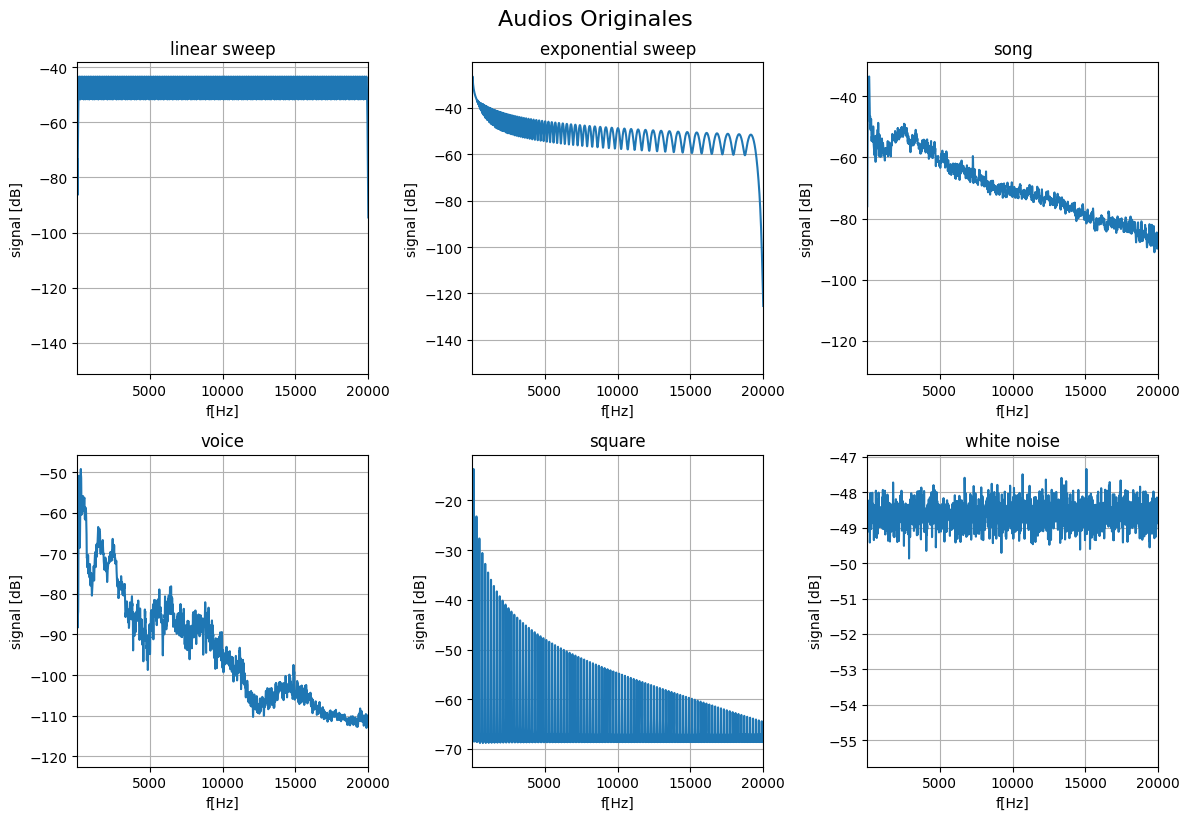

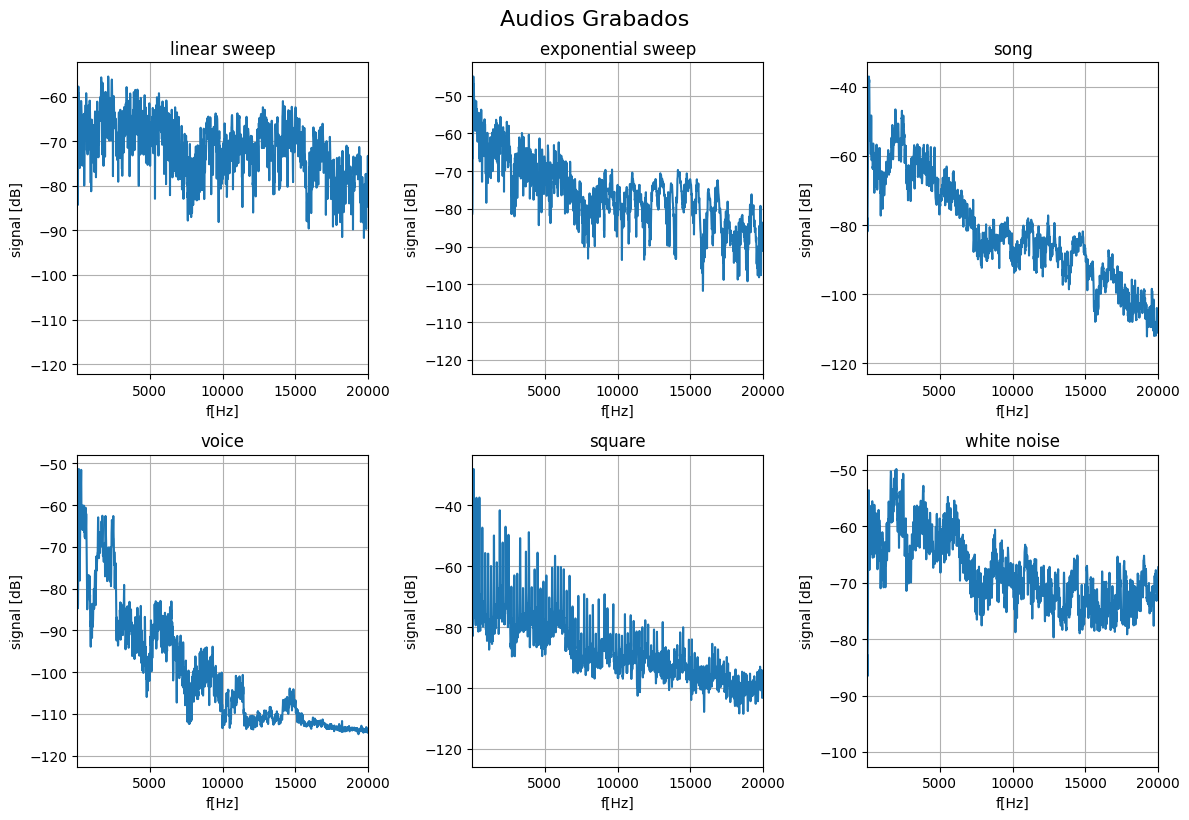

In [344]:

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)
    
    audio_original, audio_grabado = read_audios(og[i], rec[i])
    f, Pxx_den = welch(audio_original, fs=48000, window='parzen', nperseg=6000, noverlap=3000, detrend='constant', return_onesided=True, scaling='density')
    plt.xlim(20,20000)
    # Plot data in the corresponding subplot
    axs[row, col].plot(f, 10*np.log10(Pxx_den))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f[Hz]')
    axs[row, col].set_ylabel('signal [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Originales', fontsize=16,  y=1.02)


# Show the plot
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)
    
    audio_original, audio_grabado = read_audios(og[i], rec[i])
    f, Pxx_den = welch(audio_grabado, fs=48000, window='parzen', nperseg=6000, noverlap=3000, detrend='constant', return_onesided=True, scaling='density')
    plt.xlim(20,20000)
    # Plot data in the corresponding subplot
    axs[row, col].plot(f, 10*np.log10(Pxx_den))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f[Hz]')
    axs[row, col].set_ylabel('signal [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Grabados', fontsize=16,  y=1.02)
# Show the plot
plt.show()

3. A continuación se itera el proceso de adaptación del filtro para diferentes ordenes tomando como exitación al barrido lineal en frecuencia. El objetivo de este proceso es observar el comportamiento de Jo a medida que M aumenta.  

In [340]:
audio_original, audio_grabado = read_audios(og[0], rec[0])
delay_samples = calc_delay(audio_original, audio_grabado)
audio_grabado = audio_grabado[delay_samples:delay_samples+480000]


audio_grabado = audio_grabado/ np.linalg.norm(audio_grabado)
audio_original = audio_original/ np.linalg.norm(audio_original)

r = correlate(audio_original, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)
p = correlate(audio_grabado, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)

m_array = [int(x) for x in (np.logspace(0, 4.2, num = 500))]
Jo_array = []
Epsilon_array = []
for m in m_array:
    var_rec = np.var(audio_grabado)
    wo, Jo = make_filter(m, r, p, var_rec)
    Jo_array.append(Jo)
    Epsilon_array.append(Jo/var_rec)

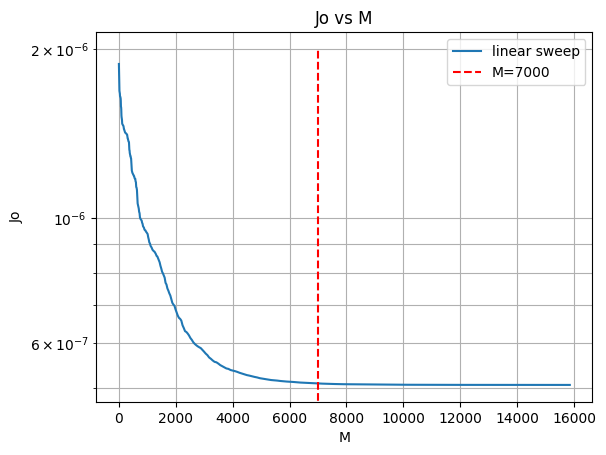

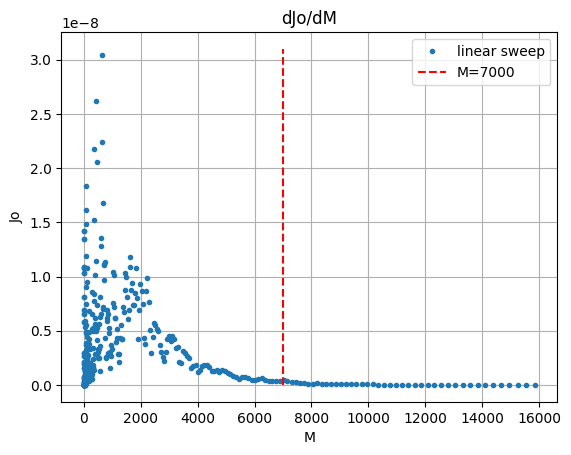

In [342]:

plt.title('Jo vs M')
plt.xlabel('M')
plt.ylabel('Jo')
plt.grid(which='both')
plt.semilogy(m_array, Jo_array,label = labels[0])
plt.plot([7000, 7000], [0, 2E-6], 'r--', label='M=7000')
plt.legend()
plt.show()
plt.title('dJo/dM')
plt.xlabel('M')
plt.ylabel('Jo')
plt.grid(which='both')
plt.plot(m_array,abs(np.gradient(Jo_array)),'.',label = labels[0])
plt.plot([7000, 7000], [0, 3.1E-8], 'r--', label='M=7000')
plt.legend()

Observando el comportamiento del MMSE, concluimos que un valor que aproxima al filtro adaptado es M=6000, ya que aproximadamente a partir de este punto podemos despreciar la caida del MMSE frente al aumento del orden del filtro empleado, ya que la derivada se aproxima a 0. Seguir aumentando M implica una mayor complejidad computacional sin mejora de la performance.

Resolver el sistema Toeplitz de la manera directa, invirtiendo matrices, es muy costoso computacionalmente. Una alternativa que mejora esta penalidad es el algoritmo recursivo de Levinson–Durbin. Este algoritmo tiene un costo computacional de Θ(n^2), mientras que si se resolviera directamente sería Θ(n^3). La funcion empleada para resolver elsistema (scipy.linalg.solve_toeplitz) utiliza esta técnica.

pto4

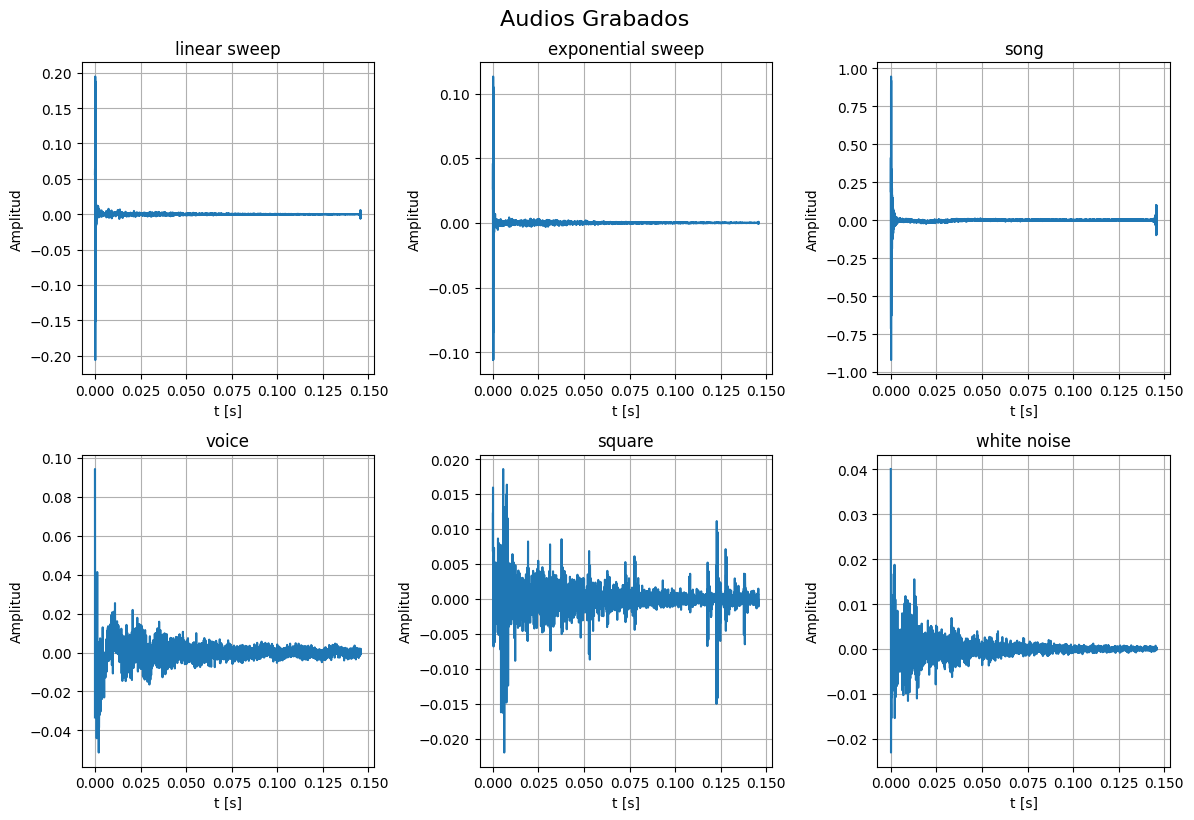

In [347]:
M=7000

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
wo_array =[]
Jo_array = []
E_array=[]
# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)

    audio_original, audio_grabado = read_audios(og[i], rec[i])
    delay_samples = calc_delay(audio_original, audio_grabado)
    audio_grabado = audio_grabado[delay_samples:delay_samples+480000]

    audio_grabado = audio_grabado
    audio_original = audio_original

    r = correlate(audio_original, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)
    p = correlate(audio_grabado, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)

    wo, Jo = make_filter(M, r, p, np.var(audio_grabado))
    Jo_array.append(Jo)
    E_array.append(Jo/np.var(audio_grabado))
    wo_array.append(wo)
    
    # Plot data in the corresponding subplot
    axs[row, col].plot(np.array(range(len(wo)))/48000,wo)
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('t [s]')
    axs[row, col].set_ylabel('Amplitud')
    axs[row, col].set_title(labels[i])
    axs[row, col].grid()
    #axs[row, col].set_xlim(20,20000)

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Grabados', fontsize=16,  y=1.02)
# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


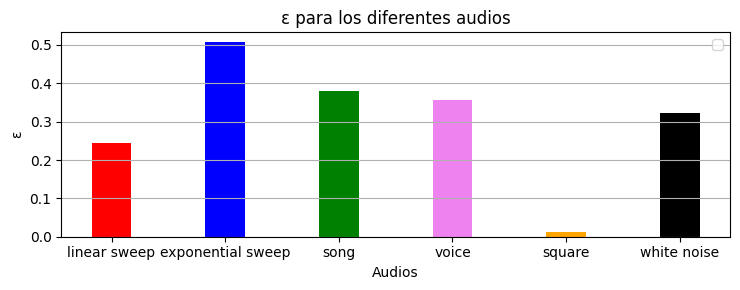

In [350]:
import matplotlib.pyplot as plt
import numpy as np



# Create an array for the x-axis positions
x = np.arange(len(labels))

# Define the width of each bar
bar_width = 0.35

# Create the grouped bar chart
plt.figure(figsize=(7.5, 3))
plt.bar(x, E_array, bar_width, color=["red", "blue", "green", "violet", "orange","black"])

# Adding labels and title
plt.xlabel('Audios')
plt.ylabel('ε')
plt.title('ε para los diferentes audios')
plt.xticks(x, labels)
plt.grid(axis="y")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


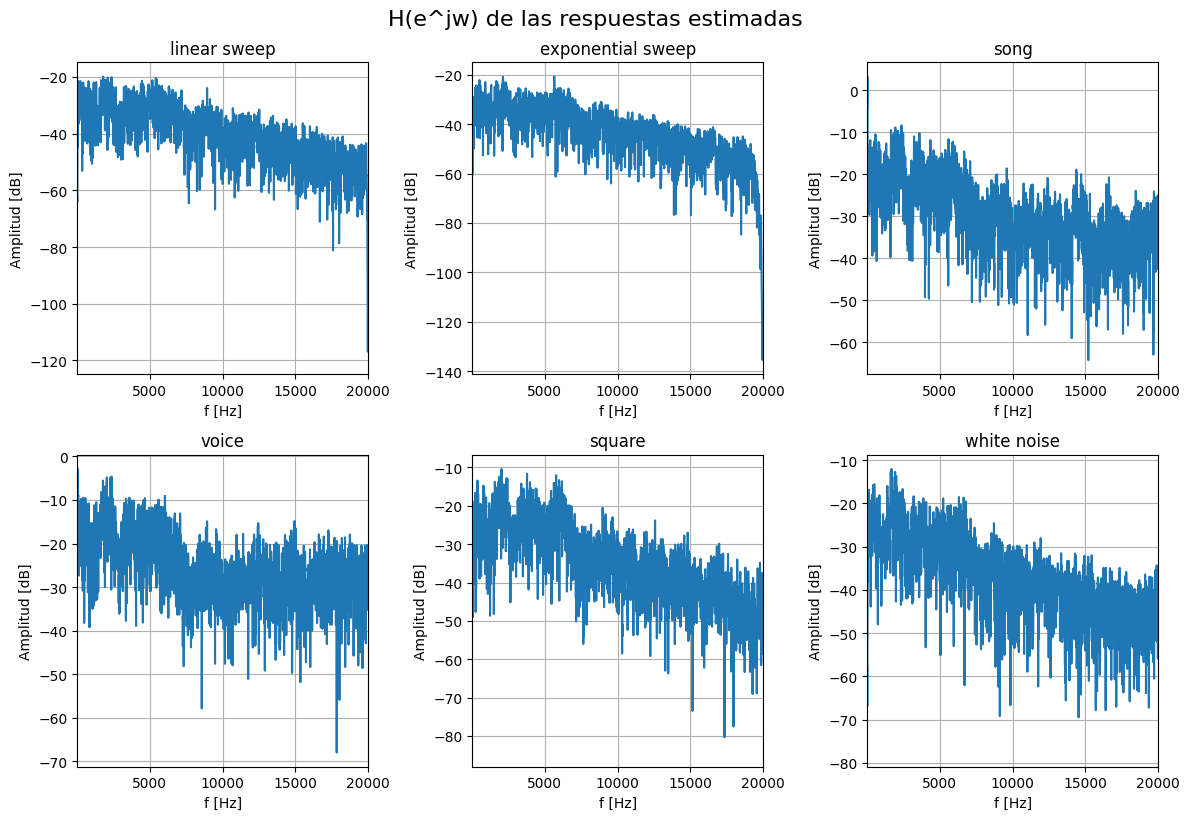

In [352]:
from scipy.signal.windows import parzen
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# Iterate over the subplots and plot data in each one

for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)


    fft_result = np.fft.fft(wo_array[i]*parzen(len(wo_array[i])))
    freqs = np.fft.fftfreq(len(fft_result), 1/48000)
    
    # Plot data in the corresponding subplot
    N = len(freqs)
    axs[row, col].plot(freqs[:N//2], 20*np.log10(abs(fft_result)[:N//2]))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f [Hz]')
    axs[row, col].set_ylabel('Amplitud [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')



# Adjust layout and spacing
plt.tight_layout()

fig.suptitle('H(e^jw) de las respuestas estimadas', fontsize=16,  y=1.02)
# Show the plot
plt.show()

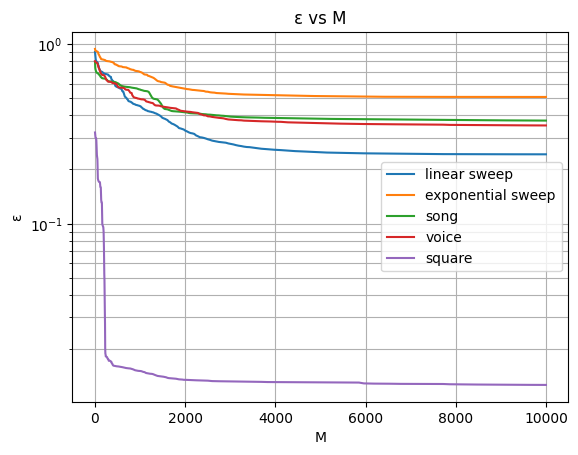

In [224]:
for n in range(len(og)):

    audio_original, audio_grabado = read_audios(og[n], rec[n])
    delay_samples = calc_delay(audio_original, audio_grabado)
    audio_grabado = audio_grabado[delay_samples:delay_samples+480000]


    audio_grabado = audio_grabado/ np.linalg.norm(audio_grabado)
    audio_original = audio_original/ np.linalg.norm(audio_original)

    r = correlate(audio_original, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)
    p = correlate(audio_grabado, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)

    m_array = [int(x) for x in (np.logspace(0, 4, num = 500))]
    Jo_array = []
    Epsilon_array = []
    for m in m_array:
        wo, Jo = make_filter(m, r, p)
        Jo_array.append(Jo)
        Epsilon_array.append(Jo/np.var(audio_grabado))

    plt.title('ε vs M')
    plt.xlabel('M')
    plt.ylabel('ε')
    plt.grid(which='both')
    plt.semilogy(m_array, Epsilon_array,label = labels[n])
    plt.legend()


In [357]:
audio_original, _ = read_audios('./audios_originales/metallica_og.wav','./grabaciones/metallica_rec.wav')
for i in range(5):
    convolved_result = np.convolve(audio_original, wo_array[i], mode='same')
    sample_rate = 48000
    convolved_result_scaled = np.int16(convolved_result/np.max(abs(convolved_result)) * 32767)
    output_file = "./fake_recordings/fake"+labels[i]+".wav"
    wav.write(output_file, sample_rate, convolved_result_scaled)



In [ ]:
filename = "fake"+labels[i]+".wav"

